In [206]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, 
precision_recall_fscore_support)
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import  KFold, train_test_split
import numpy as np
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier
from itable import PrettyTable, TableStyle, CellStyle
import pandas as pd

from imblearn.under_sampling import (RandomUnderSampler, NearMiss, 
CondensedNearestNeighbour)
from imblearn.under_sampling import (EditedNearestNeighbours, 
RepeatedEditedNearestNeighbours, TomekLinks)
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalanceCascade, EasyEnsemble
from sklearn.ensemble import  AdaBoostClassifier
%matplotlib inline
pylab.rcParams["figure.figsize"] = (18, 10)
plt.style.use("fivethirtyeight")

In [481]:
X, y = make_classification(class_sep = 1.33, weights = [.1, .9],
                          n_informative = 3,
                          n_redundant = 1, n_features = 5,
                          n_clusters_per_class = 1,
                          n_samples = 10000, flip_y = 0, random_state = 10)
pca = PCA(n_components=2)
X = pca.fit_transform(X)

y = y.astype("str")
y[y == "1"] = "L"
y[y == "0"] = "S"
y

X_train, X_test, Y_train, Y_test = train_test_split(X, y , train_size = .7,
                                                   random_state = 0)

X_1, X_2 = X_train[Y_train == "L"], X_train[Y_train == "S"]
X_1[:5]

array([[-0.57764375, -1.16153785],
       [ 1.71171987,  1.26789435],
       [ 0.76462905,  2.44312191],
       [ 2.82373238, -0.37086377],
       [ 0.31638125,  0.23101944]])

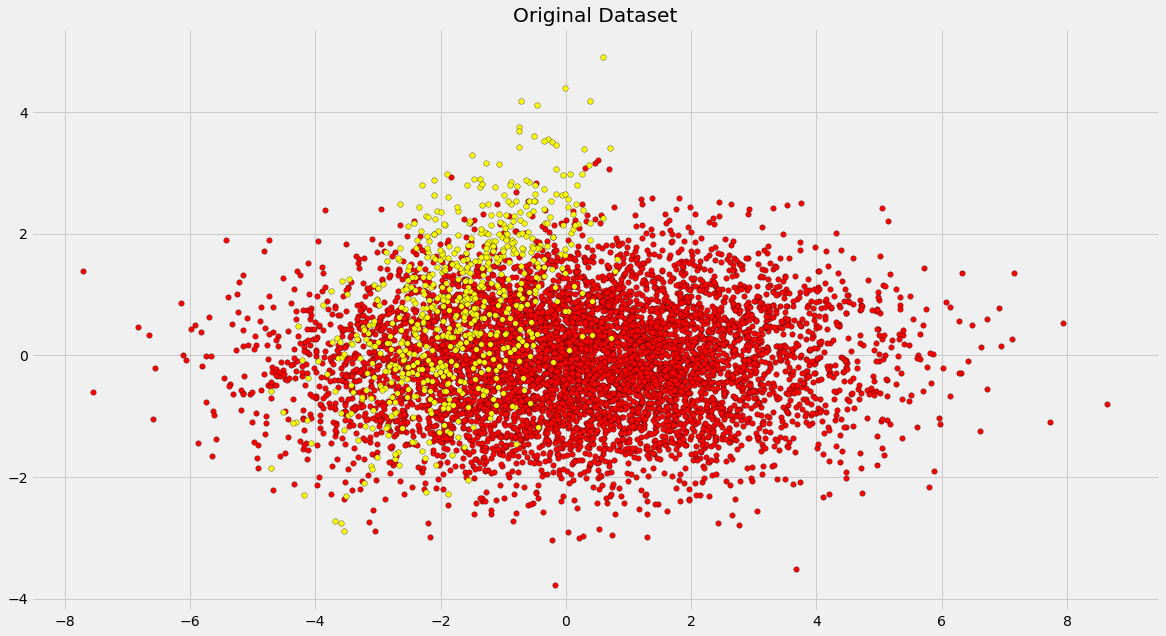

In [346]:
# Scatter Plot of the Data

fig = plt.figure(figsize = (18,10))
plt.scatter(X_1[:,0], X_1[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2[:,0], X_2[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")

#x_coords = X_1[:,0] + X_1[:,1]
#y_coords = X_2[:,0] + X_2[:,1]
#plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Original Dataset")
plt.show()

In [347]:
# Fit a Logistic Regression model

# Logistic Regression
clf_base = LogisticRegression()

# Grid Search CV
grid = { "C" : 10.0 ** np.arange(-2,3),
       "penalty" : ["l1", "l2"]}
cv = KFold(X_train.shape[0], n_folds = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, 
                   scoring = "f1_macro")

clf.fit(X_train, Y_train)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

In [348]:
coef

array([[-0.56671368,  1.02962653]])

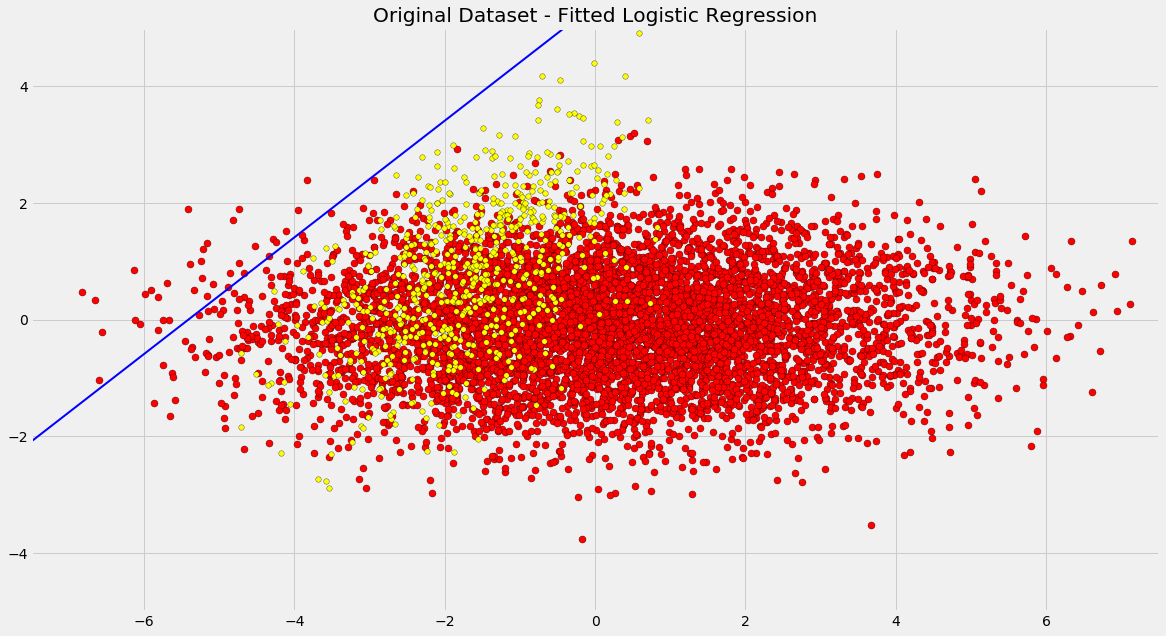

In [353]:
# Scatter Plot of the fitted logistic regression

x1 = np.linspace(-8, 10, 100)
x2 = (coef[0][0] * x1 + intercept[0])/coef[0][0]

plt.scatter(X_1[:,0], X_1[:,1], color = "red", linewidths=.3, 
            s=50, edgecolors="k")
plt.scatter(X_2[:,0], X_2[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")

plt.axis([-7.5, 7.5, -5, 5])

plt.title("Original Dataset - Fitted Logistic Regression")
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [354]:
print(classification_report(Y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.90      0.99      0.94      2679
          S       0.49      0.12      0.20       321

avg / total       0.86      0.89      0.86      3000



In [355]:
# Logistic Regression with balanced class weights

clf_base = LogisticRegression()
grid = { "C" : 10.0 ** np.arange(-2,3),
       "penalty" : ["l1", "l2"],
       "class_weight" : ["balanced"]}
cv = KFold(X_train.shape[0], n_folds = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, param_grid= grid, cv = cv, n_jobs = 8,
                   scoring = "f1_macro")

clf.fit(X_train, Y_train)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

In [356]:
coef[0][1]

0.98073444275225707

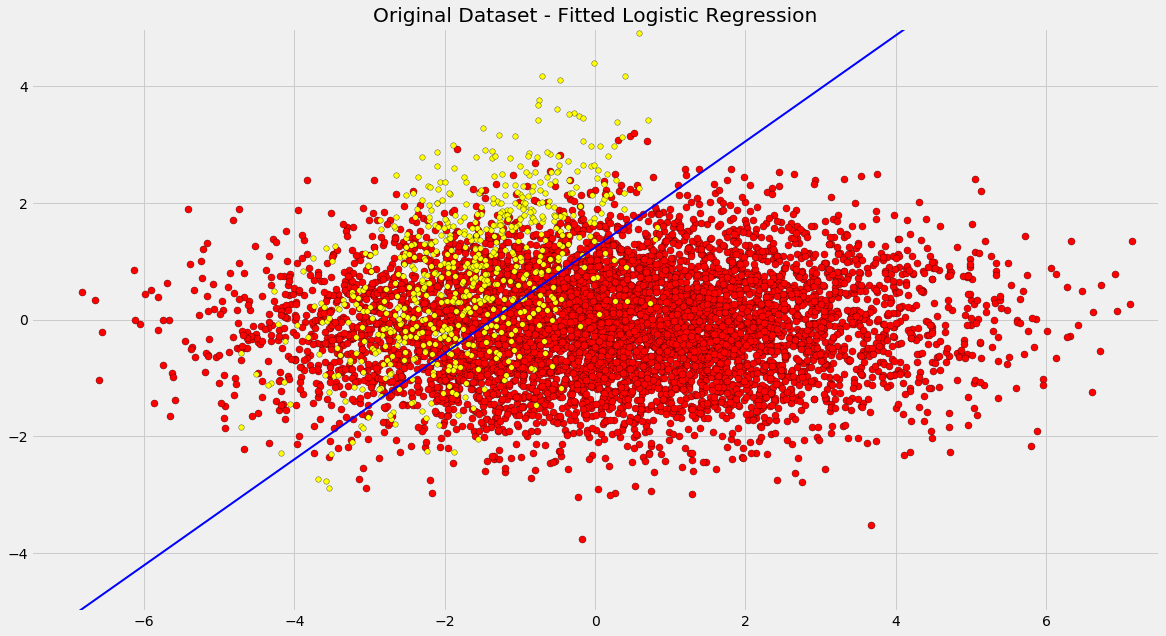

In [357]:
# Scatter Plot of the fitted logistic regression

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]
plt.scatter(X_1[:,0], X_1[:,1], color = "red", linewidths=.3, 
            s=50, edgecolors="k")
plt.scatter(X_2[:,0], X_2[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("Original Dataset - Fitted Logistic Regression")
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [358]:
print(classification_report(Y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.98      0.76      0.85      2679
          S       0.30      0.85      0.44       321

avg / total       0.90      0.77      0.81      3000



# RANDOM UNDERSAMPLING

In [359]:
KFold?

In [389]:
# Random undersampling of majority class
us = RandomUnderSampler(ratio = 0.5, random_state = 1)
X_train_res, Y_train_res = us.fit_sample(X_train, Y_train)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

clf_base = LogisticRegression()
grid = {"C" : 10.0 ** np.arange(-2, 3), 
       "penalty" : ["l1", "l2"]}

cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state = 0)

clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 1358, 'S': 679})


In [390]:
coef

array([[-0.49838718,  0.64339366]])

In [391]:
x1 = np.linspace(-8, 10, 100)
x2 = (coef[0][0] * x1 + intercept[0]) / coef[0][0]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]

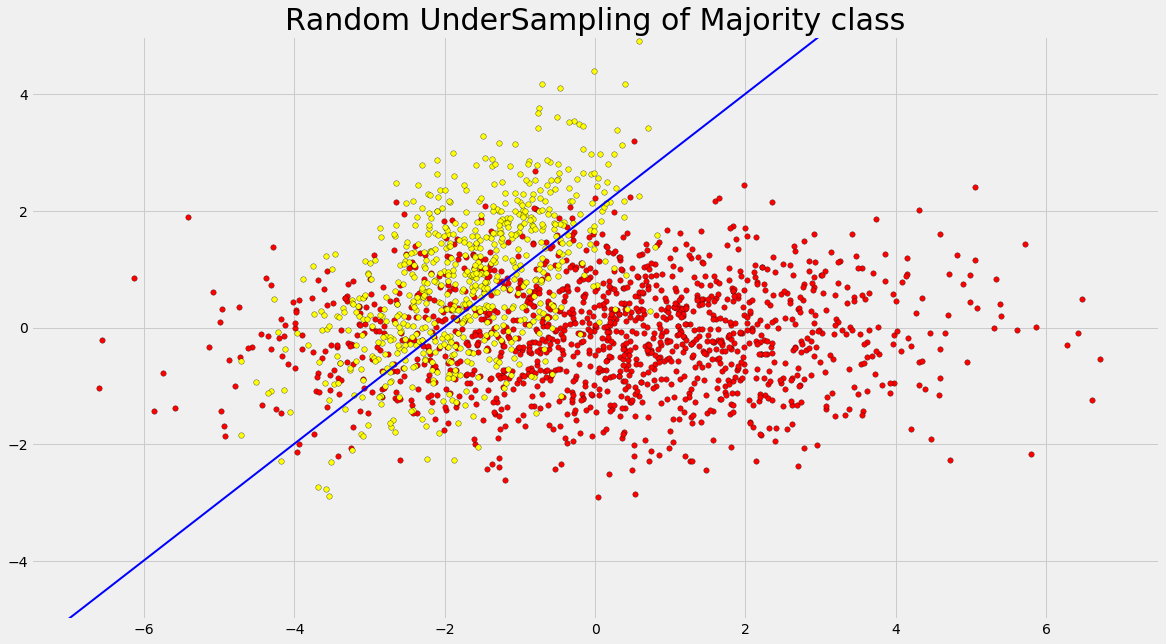

In [392]:
plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("Random UnderSampling of Majority class", Fontsize = 30)
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [393]:
print(classification_report(Y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.96      0.82      0.88      2679
          S       0.32      0.72      0.45       321

avg / total       0.89      0.81      0.84      3000



# Nearmiss

In [399]:
#Nearmiss I

us = NearMiss(ratio = 0.5, size_ngh=3, version=1, random_state=1)
X_train_res, Y_train_res = us.fit_sample(X_train, Y_train)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 1358, 'S': 679})


C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


In [400]:
clf_base = LogisticRegression()
grid = {"C" : 10.0 ** np.arange(-2,3),
       "penalty" : ["l1", "l2"]}

cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state=0)

clf = GridSearchCV(clf_base, grid,  cv=cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = (coef[0][0] * x1 + intercept[0]) / coef[0][0]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]


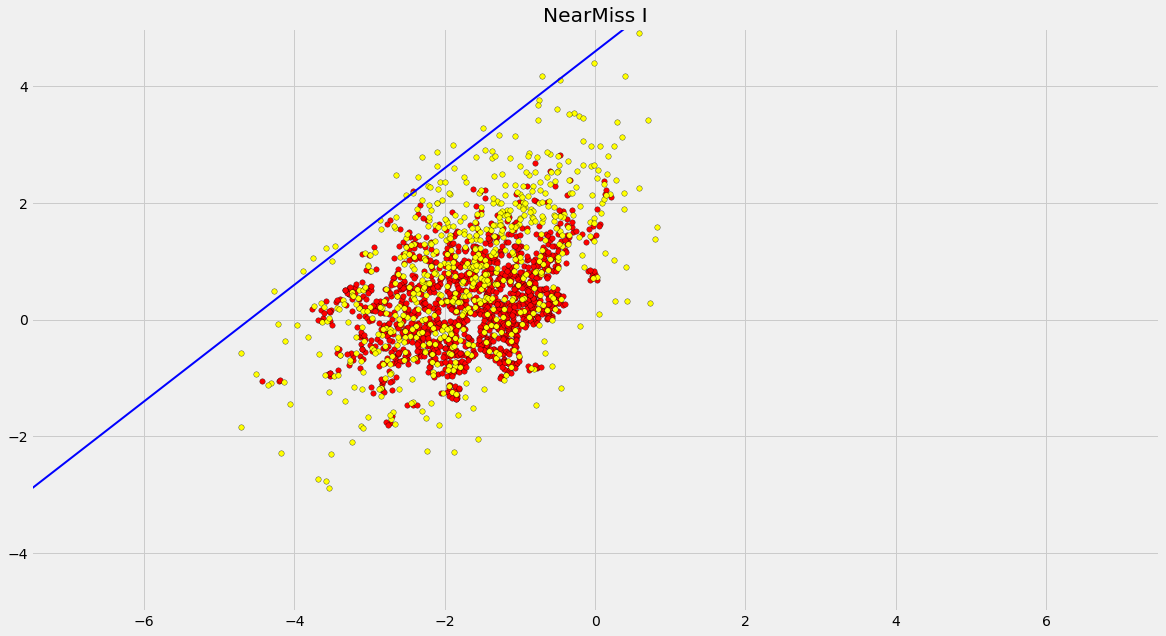

In [401]:

plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("NearMiss I")
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [402]:
print(classification_report(Y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.92      0.96      0.94      2679
          S       0.44      0.26      0.33       321

avg / total       0.86      0.89      0.87      3000



# NearMiss 2

In [407]:
# NearMiss II

us = NearMiss(ratio = 0.5, size_ngh=3, version=2, random_state=1)
X_train_res, Y_train_res = us.fit_sample(X_train_res, Y_train_res)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 1358, 'S': 679})


C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


In [408]:
clf_base = LogisticRegression()
grid = {"C" : 10.0 ** np.arange(-2,3),
       "penalty" : ["l1", "l2"]}

cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state=0)

clf = GridSearchCV(clf_base, grid,  cv=cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]

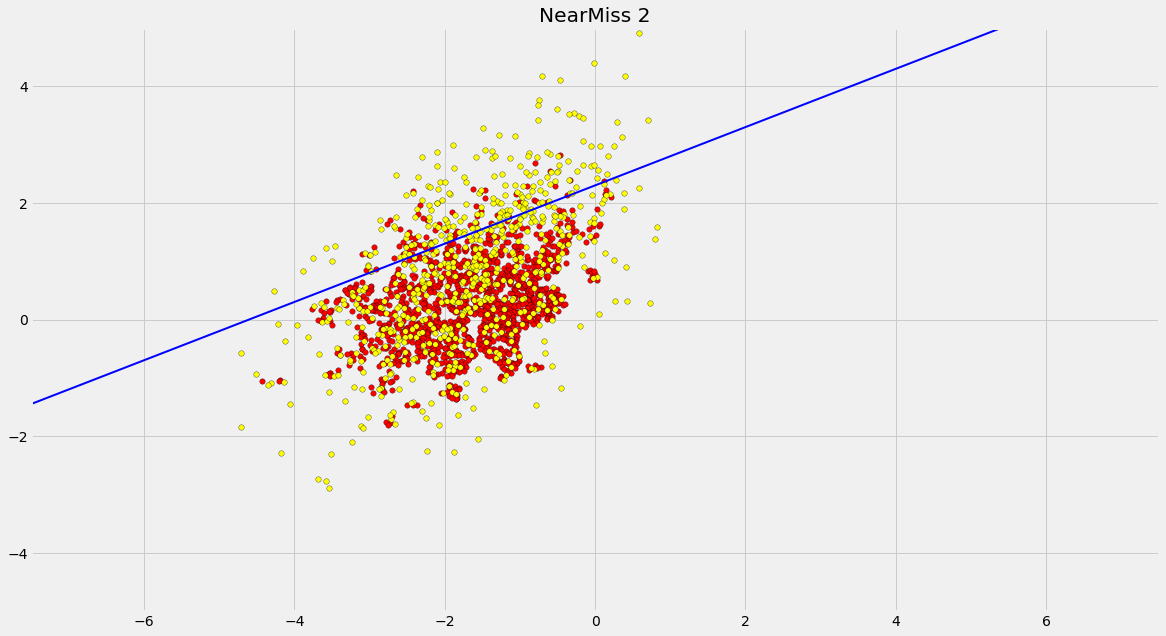

In [409]:
plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("NearMiss 2")
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [410]:
print(classification_report(Y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.92      0.96      0.94      2679
          S       0.44      0.26      0.33       321

avg / total       0.86      0.89      0.87      3000



# NearMiss III

In [411]:
# NearMiss III

us = NearMiss(ratio = 0.5, size_ngh=3, ver3_samp_ngh= 3,version=3, 
              random_state=1)
X_train_res, Y_train_res = us.fit_sample(X_train, Y_train)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 1061, 'S': 679})


C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'ver3_samp_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors_ver3' instead.
  category=DeprecationWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\under_sampling\prototype_selection\nearmiss.py:211: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be e

In [412]:
clf_base = LogisticRegression()
grid = {"C": 10.0 ** np.arange(-2, 3),
       "penalty" : ["l1", "l2"]}
cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]

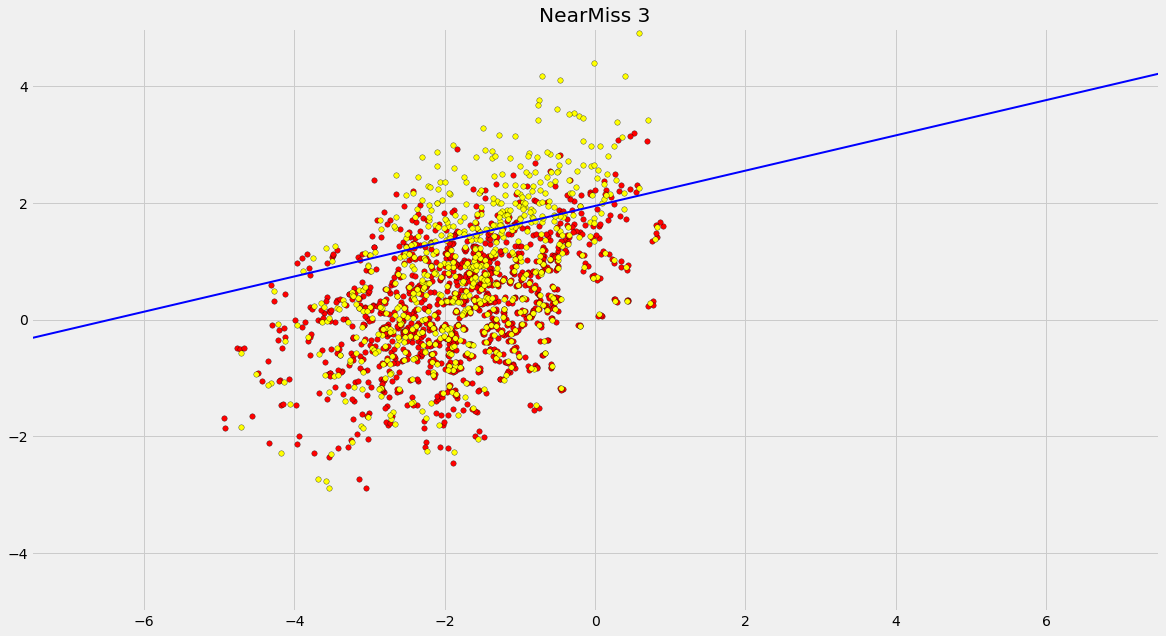

In [413]:
plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("NearMiss 3")
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [414]:
print(classification_report(Y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.92      0.96      0.94      2679
          S       0.49      0.29      0.36       321

avg / total       0.87      0.89      0.88      3000



# Condensed Nearest Neighbor (CNN)

In [419]:
# Condensed Nearest Neighbor

us = CondensedNearestNeighbour(random_state=1)
X_train_res, Y_train_res = us.fit_sample(X_train, Y_train)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 946, 'S': 679})


In [420]:
clf_base = LogisticRegression()
grid = { "C": 10.0 ** np.arange(-2, 3),
       "penalty" : ["l1", "l2"]}

cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][0]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]
coef

array([[-0.17841922,  0.53080128]])

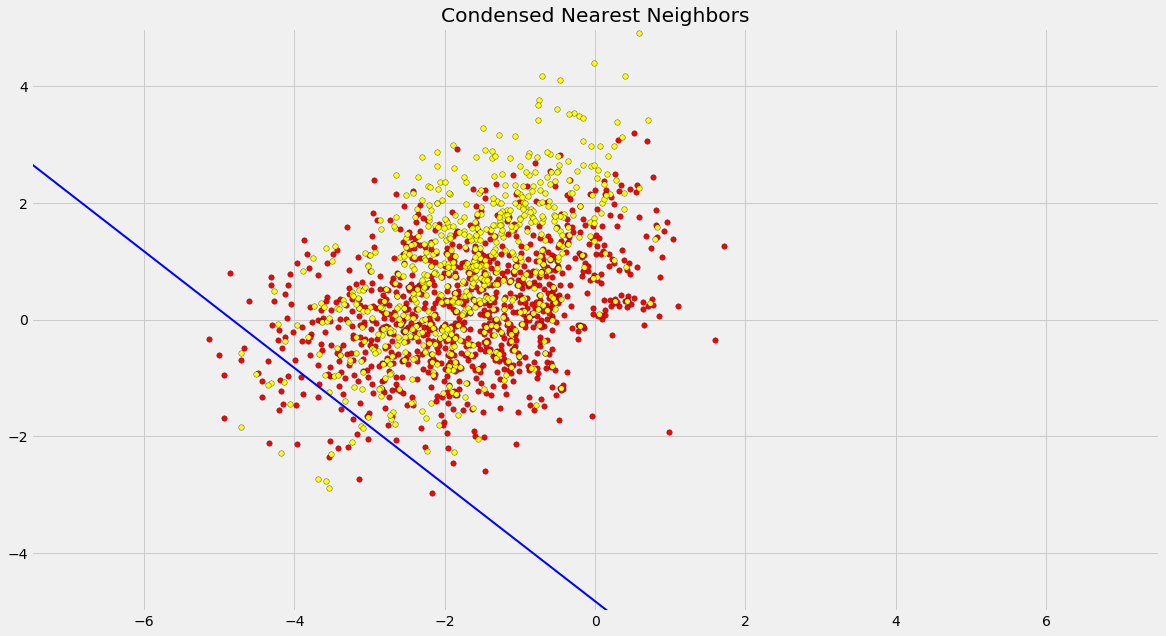

In [421]:
plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("Condensed Nearest Neighbors")
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [422]:
print(classification_report(Y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.93      0.93      0.93      2679
          S       0.45      0.44      0.44       321

avg / total       0.88      0.88      0.88      3000



# Edited Nearest Neighbor (ENN) 

In [433]:
# Edited Nearest Neighbor

us = EditedNearestNeighbours(size_ngh = 5,random_state=1)
X_train_res, Y_train_res = us.fit_sample(X_train, Y_train)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 4949, 'S': 679})


C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


In [434]:
clf_base = LogisticRegression()
grid = { "C": 10.0 ** np.arange(-2, 3),
       "penalty" : ["l1", "l2"]}

cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]

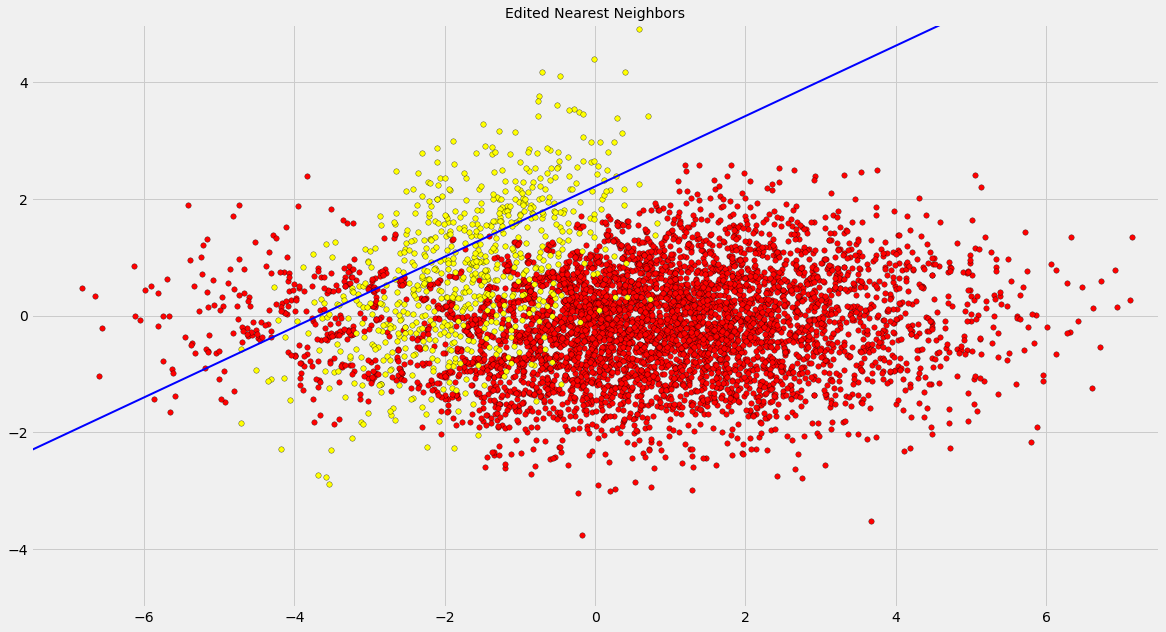

In [438]:
plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("Edited Nearest Neighbors", fontsize = 14)
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [439]:
print(classification_report(Y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.92      0.93      0.93      2679
          S       0.39      0.36      0.38       321

avg / total       0.87      0.87      0.87      3000



# Repeated Edited Nearest Neighbor

In [443]:
# Repeat Edited Nearest Neighbor
us = RepeatedEditedNearestNeighbours(size_ngh = 5, random_state = 1)
X_train_res, Y_train_res = us.fit_sample(X_train, Y_train)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 4964, 'S': 679})


In [451]:
clf_base = LogisticRegression()
grid = { "C": 10.0 ** np.arange(-2, 3),
       "penalty" : ["l1", "l2"],
       "class_weight":  ["balanced"]}

cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]

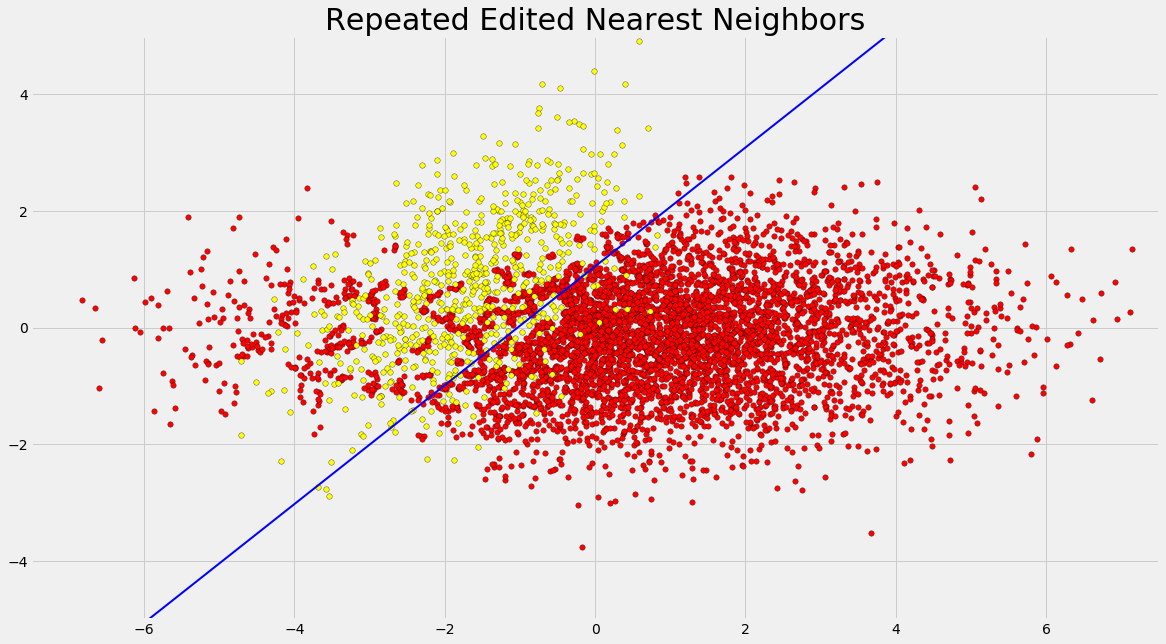

In [455]:
plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("Repeated Edited Nearest Neighbors", fontsize = 30)
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [456]:
print(classification_report(Y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.99      0.71      0.82      2679
          S       0.28      0.93      0.43       321

avg / total       0.91      0.73      0.78      3000



# TOMEK LINK REMOVAL

In [457]:
# Tomek Link Removal

us = TomekLinks(random_state = 1)
X_train_res, Y_train_res = us.fit_sample(X_train, Y_train)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 6066, 'S': 679})


In [466]:
clf_base = LogisticRegression()
grid = { "C": 10.0 ** np.arange(-2, 3),
       "penalty" : ["l1", "l2"],
       "class_weight":  ["balanced"]}

cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]

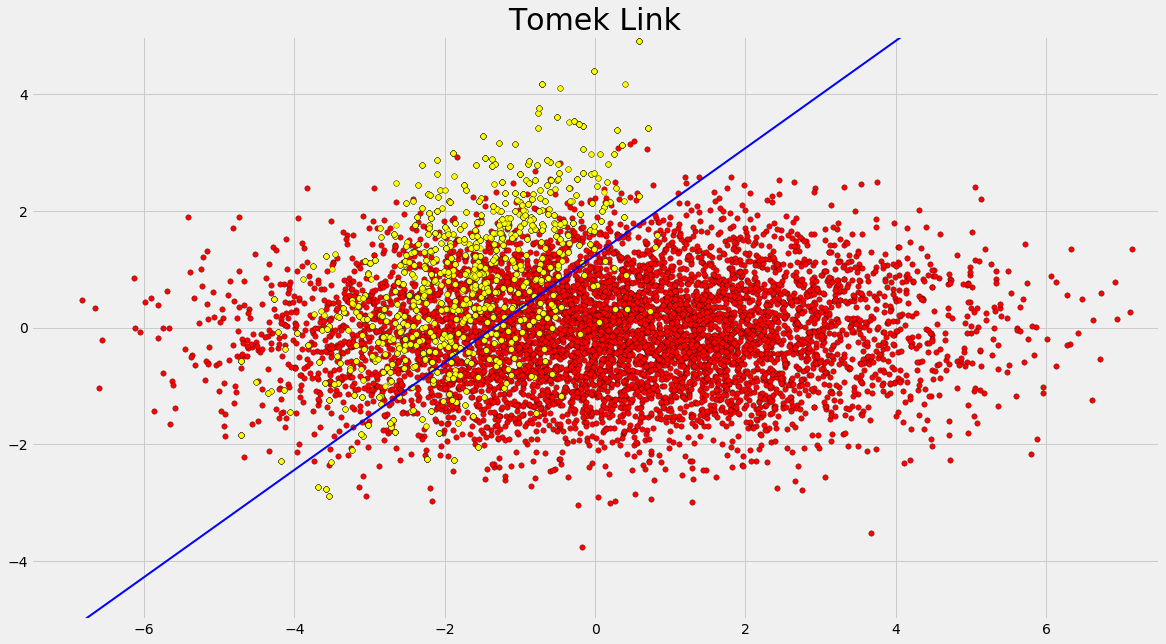

In [467]:
plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("Tomek Link", fontsize = 30)
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [468]:
print(classification_report(Y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.98      0.76      0.85      2679
          S       0.30      0.86      0.44       321

avg / total       0.90      0.77      0.81      3000



# RANDOM OVERSAMPLING

In [463]:
# Random oversampling of minority class

os = RandomOverSampler(ratio = .5, random_state = 1)
X_train_res, Y_train_res = os.fit_sample(X_train, Y_train)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 6321, 'S': 3160})


C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [476]:
clf_base = LogisticRegression()
grid = { "C": 10.0 ** np.arange(-2, 3),
       "penalty" : ["l1", "l2"]}

cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]

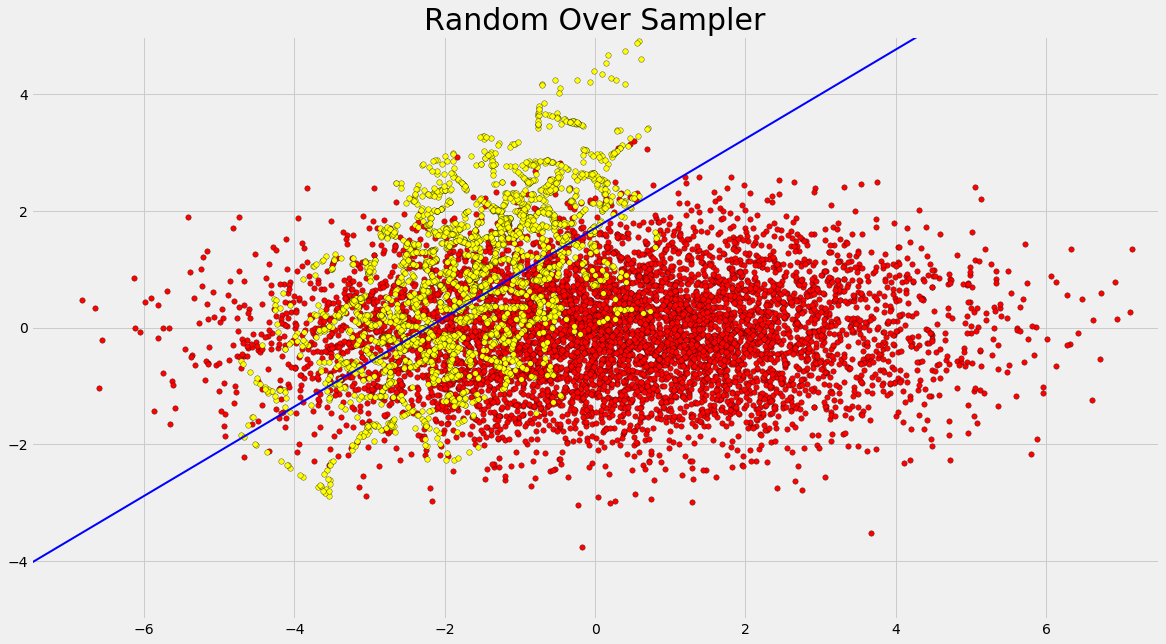

In [477]:
plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("Random Over Sampler", fontsize = 30)
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [478]:
print(classification_report(Y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.96      0.84      0.89      2679
          S       0.34      0.67      0.45       321

avg / total       0.89      0.82      0.85      3000



# SMOTE 

In [473]:
os = SMOTE(ratio = .5, k = 5, random_state = 1)
X_train_res, Y_train_res = os.fit_sample(X_train, Y_train)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 6321, 'S': 3160})


C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)


In [475]:
clf_base = LogisticRegression()
grid = { "C": 10.0 ** np.arange(-2, 3),
       "penalty" : ["l1", "l2"]}

cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]

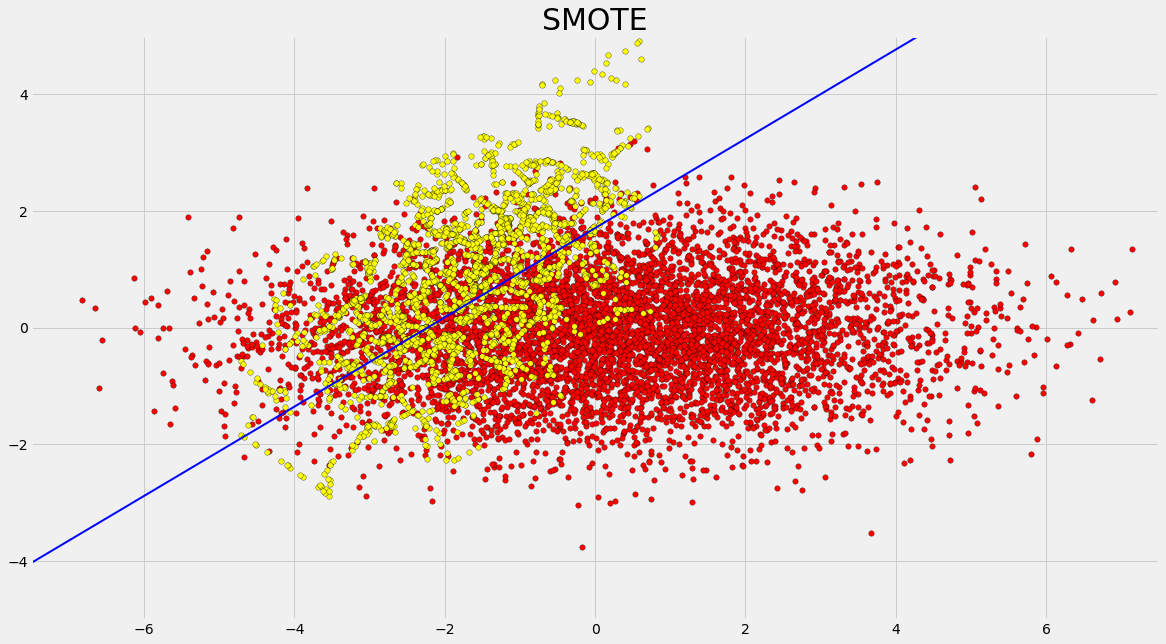

In [479]:
plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("SMOTE", fontsize = 30)
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [480]:
print(classification_report(Y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.96      0.84      0.89      2679
          S       0.34      0.67      0.45       321

avg / total       0.89      0.82      0.85      3000



# SMOTE + Tomek link Removal

In [482]:
os_us = SMOTETomek(ratio = .5, k = 5, random_state = 1)
X_train_res, Y_train_res = os_us.fit_sample(X_train, Y_train)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 5987, 'S': 2826})


C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [483]:
clf_base = LogisticRegression()
grid = { "C": 10.0 ** np.arange(-2, 3),
       "penalty" : ["l1", "l2"]}

cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]

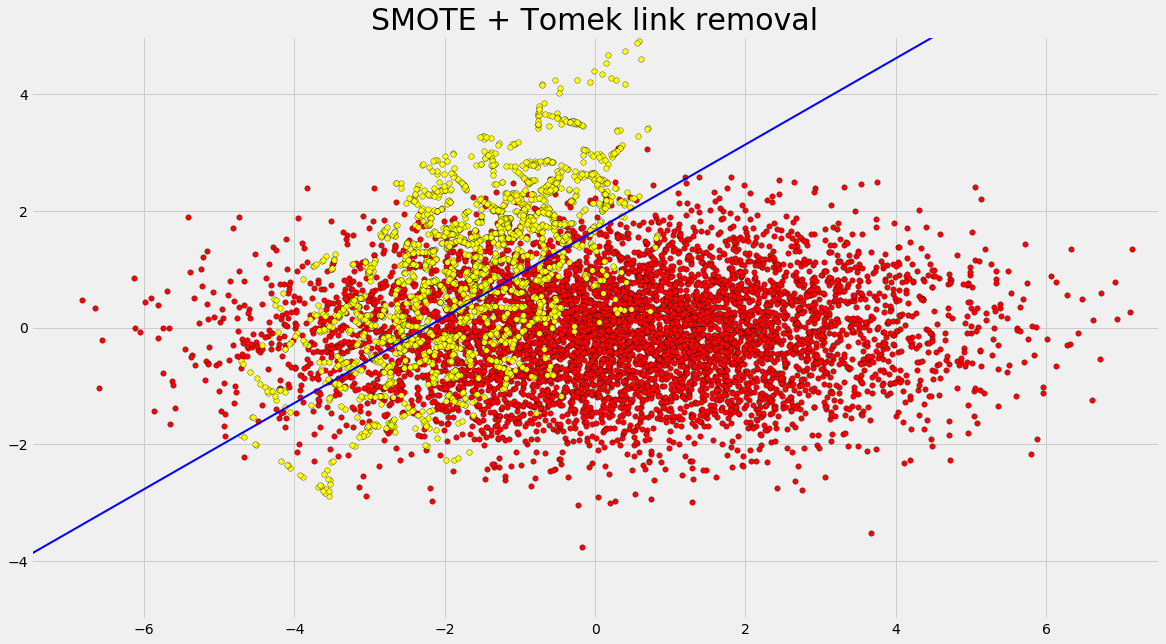

In [485]:
plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("SMOTE + Tomek link removal", fontsize = 30)
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [486]:
print(classification_report(Y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.95      0.84      0.89      2679
          S       0.33      0.67      0.44       321

avg / total       0.89      0.82      0.85      3000



# SMOTE + ENN 

In [487]:
os_us = SMOTEENN(ratio = .5, k = 5, size_ngh = 5, random_state = 1)
X_train_res, Y_train_res = os_us.fit_sample(X_train, Y_train)

print("Distribution of class labels before resampling {}".format(Counter(Y_train)))
print("Distribution of class labels after resampling {}".format(Counter(Y_train_res)))

Distribution of class labels before resampling Counter({'L': 6321, 'S': 679})
Distribution of class labels after resampling Counter({'L': 4559, 'S': 1524})


C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


In [498]:
clf_base = LogisticRegression()
grid = { "C": 10.0 ** np.arange(-2, 3),
       "penalty" : ["l1", "l2"],
       "class_weight": ["balanced"]}

cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state = 0)
clf = GridSearchCV(clf_base, grid, cv = cv, n_jobs = 8, scoring = "f1_macro")

clf.fit(X_train_res, Y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[Y_train_res == "L"]
X_2_res = X_train_res[Y_train_res == "S"]

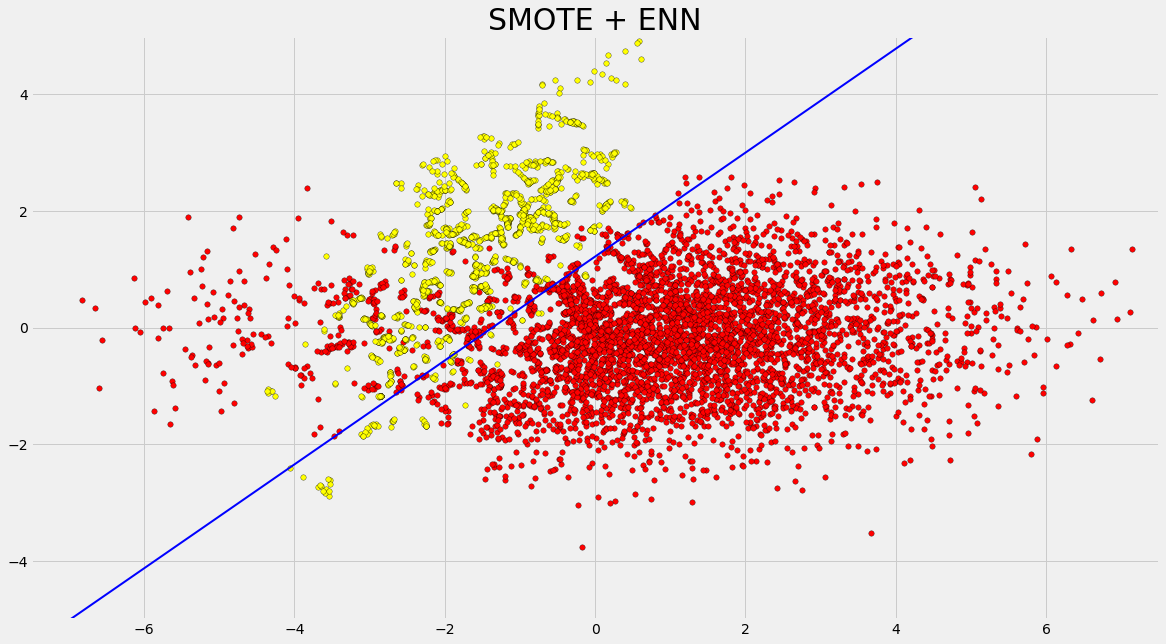

In [499]:
plt.scatter(X_1_res[:,0], X_1_res[:,1], color = "red", linewidths=.3, 
            s=30, edgecolors="k")
plt.scatter(X_2_res[:,0], X_2_res[:,1], color = "yellow", linewidths=.3, 
            s=30,edgecolors="k")


plt.axis([-7.5, 7.5, -5, 5])

plt.title("SMOTE + ENN", fontsize = 30)
plt.plot(x1, x2, color = "blue", lw = 2)
plt.show()

In [500]:
print(classification_report(Y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.98      0.76      0.85      2679
          S       0.30      0.86      0.44       321

avg / total       0.90      0.77      0.81      3000



# EASY ENSEMBLE

In [513]:
# Easy Ensemble

ens = EasyEnsemble()
X_train_res, Y_train_res = ens.fit_sample(X_train, Y_train)

Y_pred_proba = np.zeros(len(Y_test))
for idx in range(len(Y_train_res)):
    clf_base = AdaBoostClassifier()
    grid = {"n_estimators" : [10, 50, 100]}
    
    cv = KFold(X_train_res.shape[0], n_folds = 5, shuffle = True, random_state = 0)
    clf = GridSearchCV(clf_base, grid , cv = cv, n_jobs = 8, scoring = "f1_macro")
    
    clf.fit(X_train_res[idx], Y_train_res[idx])
    Y_pred_proba += clf.predict_proba(X_test)[:,0]
    
Y_pred_proba  = Y_pred_proba / len(Y_train_res)
Y_pred = (Y_pred_proba > .5).astype(int)
Y_pred = Y_pred.astype("str")

Y_pred[Y_pred == "1"] = "L"
Y_pred[Y_pred == "0"] = "S"

In [514]:
print(classification_report(Y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.99      0.68      0.81      2679
          S       0.26      0.93      0.40       321

avg / total       0.91      0.71      0.76      3000



# BALANCECASCADE

In [517]:
#BalanceCascade

ens = BalanceCascade(classifier="adaboost", random_state = 1)
X_train_res, Y_train_res = ens.fit_sample(X_train, Y_train)

Y_pred_proba = np.zeros(len(Y_test))
for idx in range(len(Y_train_res)):
    # imblearn uses AdaBoostClassifier with default hyperparams to select subsets 
    # a variant implementation with grid search for each subsample is shown in the
    # next cell
    clf = AdaBoostClassifier(random_state = 1)
    clf.fit(X_train_res[idx], Y_train_res[idx])
    Y_pred_proba += clf.predict_proba(X_test)[:,0]
    
Y_pred_proba = Y_pred_proba / len(Y_train_res)
Y_pred = (Y_pred_proba > .5).astype(int)
Y_pred = Y_pred.astype("str")
Y_pred[Y_pred == "1"] = "L"
Y_pred[Y_pred == "0"] = "S"

IndexError: arrays used as indices must be of integer (or boolean) type

In [518]:
print(classification_report(Y_test,clf.predict(X_test)))

             precision    recall  f1-score   support

          L       0.99      0.68      0.81      2679
          S       0.26      0.93      0.40       321

avg / total       0.91      0.71      0.76      3000

